## GLS map-making for I component using the linear operators explicitly

This example illustrates the GLS map-making for I component only using linear operators explicitly. The same can be achieved using dedicated wrapper function for GLS map-making.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import brahmap

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
### Random number generator
seed = 455
rng = np.random.default_rng(seed=seed)

### Producing the input map, pointings and TOD

In [3]:
### Simulation parameters

# Numerical precisions
dtype_int = np.int32  # Numerical precision for pointing indices
dtype_float = np.float64  # Numerical precision for TOD and output maps

# Map dimensions
pix_x = 16
pix_y = 32
npix = pix_x * pix_y

# Number of samples
nsamples = npix * 6

# Number of bad samples
nbad_samples = npix

In [4]:
### Generating random pointing indices
pointings = rng.integers(low=0, high=npix, size=nsamples, dtype=dtype_int)

### Generating pointing flags
# Samples marked with flag `False` are considered as the bad samples and are excluded from map-making
pointings_flag = np.ones(nsamples, dtype=bool)
bad_samples = rng.integers(low=0, high=nsamples, size=nbad_samples)
pointings_flag[bad_samples] = False

In [5]:
### Generating random input map
input_I_map = rng.uniform(low=-10.0, high=10.0, size=npix).astype(dtype=dtype_float)

In [6]:
### Scanning the input map
tod = np.zeros(nsamples, dtype=dtype_float)
for idx, pix in enumerate(pointings):
    tod[idx] += input_I_map[pix]

### Producing the GLS map

In [ ]:
### Creating an inverse noise covariance operator (unit diagonal operator in this case)
inv_cov = brahmap.InvNoiseCovLO_Diagonal(
    size=nsamples,
    input=1.0,
    dtype=dtype_float,
)

In [8]:
### Processing the pointing information
processed_samples = brahmap.ProcessTimeSamples(
    npix=npix,
    pointings=pointings,
    pointings_flag=pointings_flag,
    solver_type=brahmap.SolverType.I,  # we are solving only I map
    noise_weights=inv_cov.diag,
    dtype_float=dtype_float,
)


-------------------------- ProcessTimeSamples Summary --------------------------
Processed 3072 time samples for npix=512
Found 7 pathological pixels on the map
Map-maker will take into account only 505 pixels
--------------------------------------------------------------------------------


In [9]:
### Creating pointing operator
pointing_LO = brahmap.PointingLO(processed_samples)

### Creating block-diagonal preconditioner
precond_LO = brahmap.BlockDiagonalPreconditionerLO(processed_samples)

In [10]:
### Creating operators for linear equation A.x = b
A = pointing_LO.T * inv_cov * pointing_LO
b = pointing_LO.T * inv_cov * tod

In [11]:
### Solving GLS using pcg
# We are solving for x in the linear equation A.x = b
map_vector, _ = sp.sparse.linalg.cg(A=A, b=b, M=precond_LO)

In [12]:
### Producing output map masked for bad pixels
# `map_vector` obtained in the previous step corresponds only to the pixels that
# are being used in map-making. To produce the final output maps, we need to
# include the bad pixels and mask them appropriately
output_map = brahmap.separate_map_vectors(
    map_vector=map_vector, processed_samples=processed_samples
)

### Comparing the input and output map

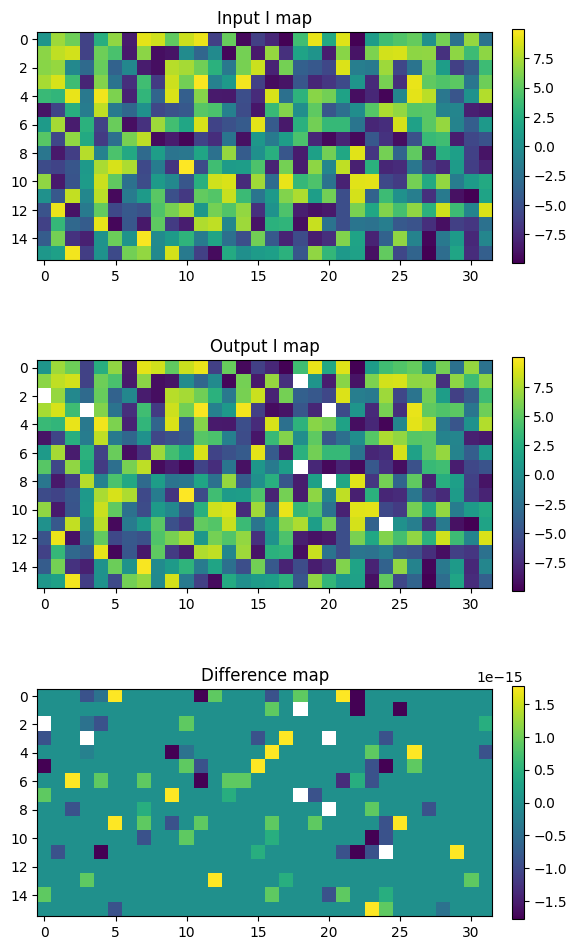

In [13]:
### Plotting and comparing the input and output map

plt.figure(figsize=(6, 10))

plt.subplot(311)
img = plt.imshow(input_I_map.reshape((pix_x, pix_y)))
plt.title("Input I map")
plt.colorbar(img, fraction=0.024, pad=0.04)

plt.subplot(312)
img = plt.imshow(output_map.reshape((pix_x, pix_y)))
plt.title("Output I map")
plt.colorbar(img, fraction=0.024, pad=0.04)

plt.subplot(313)
img = plt.imshow(
    output_map.reshape((pix_x, pix_y)) - input_I_map.reshape((pix_x, pix_y))
)
plt.title("Difference map")
plt.colorbar(img, fraction=0.024, pad=0.04)

plt.tight_layout()

### Comments on the result

The white pixels in the output map indicate the bad pixels excluded from the map-making. These are the same pixels reported by `ProcessTimeSamples`. The pixel indices corresponding to the bad pixels can be accessed with `processed_samples.bad_pixels`.

In [14]:
processed_samples.bad_pixels

array([ 50,  64,  99, 116, 242, 276, 376])